# Conservational Properties

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# numerics
import jax
import jax.numpy as jnp
from jax import grad

# 64-bit precision
jax.config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# jf1uids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids._physics_modules._stellar_wind.stellar_wind_options import WindConfig
from jf1uids.option_classes.simulation_config import SPHERICAL
from jf1uids.option_classes.simulation_config import finalize_config

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
geometry = SPHERICAL
box_size = 1.0
num_cells = 101

fixed_timestep = False

return_snapshots = True
num_snapshots = 40

# activate stellar wind
stellar_wind = False

# setup simulation config
config = SimulationConfig(
    geometry = geometry,
    box_size = box_size, 
    num_cells = num_cells,
    wind_config = WindConfig(
        stellar_wind = stellar_wind,
    ),
    fixed_timestep = fixed_timestep,
    return_snapshots = return_snapshots,
    num_snapshots = num_snapshots
)

helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [3]:
# time domain
dt_max = 0.1
C_CFL = 0.8
t_end = 0.2

# SOD shock tube
shock_pos = 0.5

r = helper_data.geometric_centers

rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = construct_primitive_state(
    config = config,
    registered_variables = registered_variables,
    density = rho,
    velocity_x = u,
    gas_pressure = p
)

params = SimulationParams(C_cfl = C_CFL, dt_max = dt_max, gamma = gamma, t_end = t_end)

## Conservation test of the simulation

In [4]:

def init_shock_problem(num_cells, config, params, first_order_fallback = False):
    config = config._replace(num_cells = num_cells, grid_spacing = config.box_size / (num_cells - 1), first_order_fallback = first_order_fallback)
    params = params._replace(dt_max = dt_max)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    rho = jnp.where(r < shock_pos, 1.0, 0.125)
    u = jnp.zeros_like(r)
    p = jnp.where(r < shock_pos, 1.0, 0.1)

    # get initial state
    initial_state = construct_primitive_state(
        config = config,
        registered_variables = registered_variables,
        density = rho,
        velocity_x = u,
        gas_pressure = p
    )

    config = finalize_config(config, initial_state.shape)

    return initial_state, config, params, helper_data

initial_state_shock100, config_shock100, params_shock100, helper_data_shock100 = init_shock_problem(101, config, params)
checkpoints_shock100 = time_integration(initial_state_shock100, config_shock100, params_shock100, helper_data_shock100, registered_variables)

initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order = init_shock_problem(101, config, params, True)
checkpoints_shock100_first_order = time_integration(initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order, registered_variables)

initial_state_shock, config_shock, params_shock, helper_data_shock = init_shock_problem(2001, config, params, True)
checkpoints_shock2000 = time_integration(initial_state_shock, config_shock, params_shock, helper_data_shock, registered_variables)

For spherical geometry, only HLL is currently supported. Also, only the unsplit mode has been tested.
Setting HLL Riemann solver for spherical geometry.
Setting minmod limiter for spherical geometry
Setting MUSCL time integrator for spherical geometry
Due to different implementation approaches, currently only a limited set of Riemann solver and limiters work in unsplit mode, namely LAX_FRIEDRICHS with VAN_ALBADA limiter.
Switching to split mode.
Automatically setting reflective left and open right boundary for spherical geometry.
For spherical geometry, only HLL is currently supported. Also, only the unsplit mode has been tested.
Setting HLL Riemann solver for spherical geometry.
Setting minmod limiter for spherical geometry
Setting MUSCL time integrator for spherical geometry
Due to different implementation approaches, currently only a limited set of Riemann solver and limiters work in unsplit mode, namely LAX_FRIEDRICHS with VAN_ALBADA limiter.
Switching to split mode.
Automatically 

### Visualization of the mass and energy development

[ 0.00000000e+00  0.00000000e+00  1.11287917e-14  1.11287917e-14
  2.22575833e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.22575833e-14  0.00000000e+00  1.11287917e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11287917e-14 -1.11287917e-14  0.00000000e+00
 -1.11287917e-14 -1.11287917e-14 -1.11287917e-14 -1.11287917e-14
 -1.11287917e-14 -1.11287917e-14 -2.22575833e-14 -2.22575833e-14
 -2.22575833e-14 -2.22575833e-14 -2.22575833e-14 -2.22575833e-14
 -2.22575833e-14 -2.22575833e-14 -2.22575833e-14 -2.22575833e-14
 -4.45151666e-14 -3.33863750e-14 -3.33863750e-14 -4.45151666e-14]
0.0
0.0


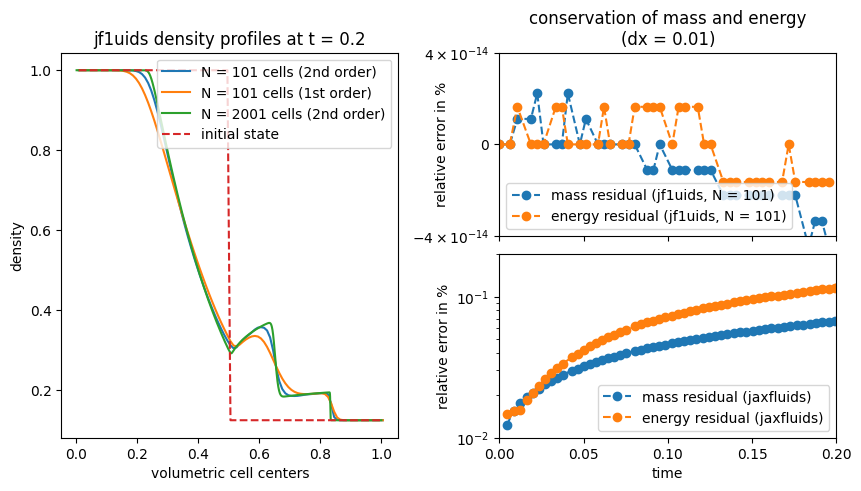

In [5]:
relative_mass_error = (checkpoints_shock100.total_mass - checkpoints_shock100.total_mass[0]) / checkpoints_shock100.total_mass[0] * 100
relative_energy_error = (checkpoints_shock100.total_energy - checkpoints_shock100.total_energy[0]) / checkpoints_shock100.total_energy[0] * 100

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, figure=fig)

gs.update(wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(gs[:, 0])  # Left plot spanning both rows
ax2 = fig.add_subplot(gs[0, 1])  # Top-right plot
ax3 = fig.add_subplot(gs[1, 1])  # Bottom-right plot

ax2.plot(checkpoints_shock100.time_points, relative_mass_error, "o--", label="mass residual (jf1uids, N = 101)")
print(relative_mass_error)

ax3.set_xlabel("time")
ax2.legend(loc = "upper left")

ax2.set_ylabel("relative error in %")

ax2.yaxis.set_label_coords(-0.15, 0.5)

ax2.plot(checkpoints_shock100.time_points, relative_energy_error, "o--", label="energy residual (jf1uids, N = 101)")

ax2.legend(loc = "lower left")
ax2.set_title("conservation of mass and energy\n(dx = 0.01)")
ax2.set_xticklabels([])
ax2.set_xlim(0, 0.2)
ax3.set_xlim(0, 0.2)

# less x ticks
ax3.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])
ax2.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])

sod_error = jnp.load("../data/sod_errors.npy")
times_jaxfluids, mass_errors_jaxfluids, energy_errors_jaxfluids = sod_error
ax3.plot(times_jaxfluids, mass_errors_jaxfluids, "o--", label="mass residual (jaxfluids)")
ax3.plot(times_jaxfluids, energy_errors_jaxfluids, "o--", label="energy residual (jaxfluids)")
ax3.set_ylim(1e-2, 0.2)

ax3.set_ylabel("relative error in %")

ax3.tick_params(axis='y')

ax3.set_yscale("log")
ax2.set_yscale("symlog")
ax2.set_ylim(-4e-14, 4e-14)

ax3.legend(loc = "lower right")

ax1.plot(helper_data_shock100.volumetric_centers, checkpoints_shock100.states[-1,0,:], label="N = 101 cells (2nd order)")
ax1.plot(helper_data_shock100_first_order.volumetric_centers, checkpoints_shock100_first_order.states[-1,0,:], label="N = 101 cells (1st order)")
ax1.plot(helper_data_shock.volumetric_centers, checkpoints_shock2000.states[-1,0,:], label="N = 2001 cells (2nd order)")

ax1.set_title("jf1uids density profiles at t = 0.2")

# also plot the initial state in -- for reference
ax1.plot(helper_data_shock100.volumetric_centers, initial_state_shock100[0], "--", label="initial state")

ax1.set_xlabel("volumetric cell centers")
ax1.set_ylabel("density")

ax1.legend(loc = "upper right")

print(checkpoints_shock100.runtime)
print(checkpoints_shock2000.runtime)

plt.savefig("../figures/conservational_properties.png")